In [113]:
try:
    import pandas as pd
except:
    ! pip3 install pandas
    import pandas as pd

In [114]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
try:
    import seaborn as sns
except:
    ! pip3 install seaborn
    import seaborn as sns 
try:
    import matplotlib as plt
    import matplotlib.pylab as plt
except:
    ! pip3 install matplotlib
    import matplotlib as plt
    import matplotlib.pylab as plt

In [115]:
try:
    import numpy as np
except:
    ! pip3 install numpy
    import numpy as np

try:
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
except:
    ! pip3 install scikit-learn
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

try:
    import statsmodels
    from statsmodels.formula.api import ols
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except:
    ! pip3 install statsmodels
    import statsmodels
    from statsmodels.formula.api import ols
    from statsmodels.stats.outliers_influence import variance_inflation_factor

In [116]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')

In [117]:
df = df.drop(["Id"], axis=1)
df_test = df_test.drop(["Id"], axis=1)

In [118]:
df = df.rename({"1stFlrSF": "FstFlrSF",
           "2ndFlrSF": "SndFlrSF", 
           "3SsnPorch": "TSsnPorch"}, axis = "columns")
df_test = df_test.rename({"1stFlrSF": "FstFlrSF",
           "2ndFlrSF": "SndFlrSF", 
           "3SsnPorch": "TSsnPorch"}, axis = "columns")

In [119]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [120]:
quantitative.remove('MSSubClass')

In [121]:
qualitative = qualitative + ["MSSubClass"]

In [122]:
df[['Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtCond']] = df[['Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtCond']].fillna('noexist')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0) # 창고를 지은 년도를 설명하는 변수 
df['LotFrontage'] = df['LotFrontage'].fillna(0) # 도로와 직선으로 맞닿아 있는것을 설명하는 변수. 

df_test[['Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtCond']] = df[['Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtCond']].fillna('noexist')
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(0) # 창고를 지은 년도를 설명하는 변수 
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(0) # 도로와 직선으로 맞닿아 있는것을 설명하는 변수. 

In [123]:
df['BsmtExposure'][948] = "No" # No라는 변수가 존재한다. 이를 사람이 실수하여 잘못 넣었다고 추정했다.
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode().values[0]) # 최빈값
df['MasVnrArea'] = df['MasVnrArea'].fillna(np.mean(df["MasVnrArea"])) # 평균값
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode().values[0]) # 최빈값


df_test['BsmtExposure'][948] = "No" # No라는 변수가 존재한다. 이를 사람이 실수하여 잘못 넣었다고 추정했다.
df_test['MasVnrType'] = df_test['MasVnrType'].fillna(df['MasVnrType'].mode().values[0]) # 최빈값
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(np.mean(df["MasVnrArea"])) # 평균값
df_test['Electrical'] = df_test['Electrical'].fillna(df['Electrical'].mode().values[0]) # 최빈값

### 더미 변수 만들어 주기

In [124]:
df_all = df.copy()
df_all_temp = pd.concat([df_all,df_test])
df_all_temp['MSSubClass'] = df_all_temp['MSSubClass'].astype('category')
df_temp = pd.get_dummies(df_all_temp)["GarageQual_Ex"]

In [125]:
df_all_temp = pd.get_dummies(df_all_temp, drop_first=True)

In [126]:
df_all_temp.insert(loc=151, column='GarageQual_Ex', value=df_temp)

In [127]:
y_all = df_all_temp['SalePrice']
df_all_temp = df_all_temp.drop('SalePrice', axis=1)

df_all = df_all_temp.iloc[:1460,:]
y_all = y_all.iloc[:1460]
df_test_kaggle = df_all_temp.iloc[1460:,:]

### 다중공선성 분석

In [128]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df_all.values, i) for i in range(df_all.shape[1])]
vif["features"] = df_all.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)

### 다중공선성이 10 이하인 변수만 추출

In [129]:
low_vif = list(vif[vif["VIF Factor"] <= 10].features)

### 조건 수 1.10e+06

In [130]:
result_all = sm.OLS(y_all, df_all[low_vif]).fit()
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     353.2
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:09:05   Log-Likelihood:                -17075.
No. Observations:                1460   AIC:                         3.448e+04
Df Residuals:                    1294   BIC:                         3.536e+04
Df Model:                         166                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Condition1_RRNe       -8258.69

### RMSE 69392

In [131]:
score = 0 
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_all)):
    df_train, df_train_y = df_all.iloc[idx_train], y_all.iloc[idx_train]
    df_test, df_test_y = df_all.iloc[idx_test], y_all.iloc[idx_test]
    result_temp = sm.OLS(df_train_y, df_train).fit()
    yhat = result_temp.predict(df_test)
    temp_score = np.sqrt(mean_squared_error(df_test_y, yhat))
    score += temp_score

print(score/5)

69392.40028135313


### 예측한 집 값에 마이너스가 들어간 데이터가 존재한다.

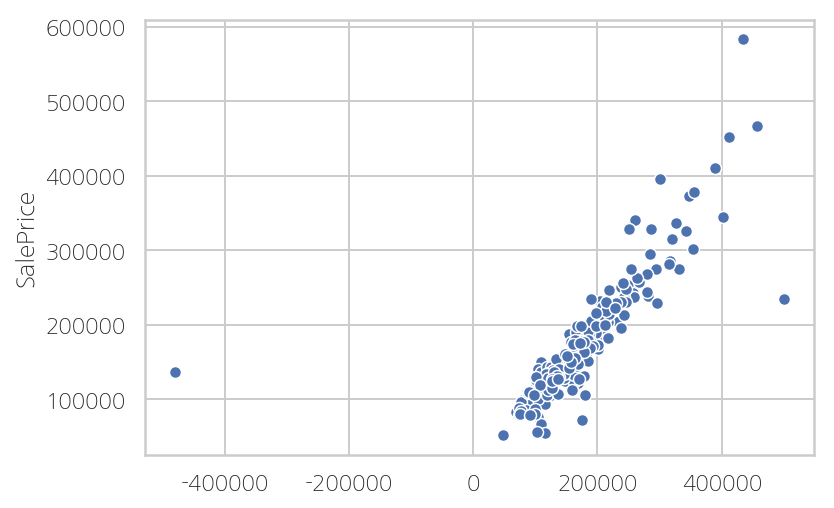

In [132]:
sns.scatterplot(yhat, df_test_y)

## Using only related cols
### P value가 0.01보다 낮은 변수만 추출

In [133]:
related_cols = result_all.pvalues[result_all.pvalues < 0.01]
related_cols = list(related_cols.index)

### RMSE 36721

In [134]:
df_related = df_all[[col for col in df_all.columns if col in related_cols]]
df_test_kaggle = df_test_kaggle[[col for col in df_test_kaggle.columns if col in related_cols]]

y_related = y_all.copy()
score = 0
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_related)):
    df_train, df_train_y = df_related.iloc[idx_train], y_related.iloc[idx_train]
    df_test, df_test_y = df_related.iloc[idx_test], y_related.iloc[idx_test]
    result_related = sm.OLS(df_train_y, df_train).fit()
    yhat = result_related.predict(df_test)
    temp_score = np.sqrt(mean_squared_error(df_test_y, yhat))
    score += temp_score
print(score/5)

36721.873318814316


In [135]:
print(result_related.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1204.
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:09:14   Log-Likelihood:                -13791.
No. Observations:                1168   AIC:                         2.765e+04
Df Residuals:                    1133   BIC:                         2.783e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
BsmtFullBath           1.46e+04 

In [136]:
df_test_kaggle["BsmtFullBath"] = df_test_kaggle["BsmtFullBath"].fillna(df_test_kaggle["BsmtFullBath"].mean())
df_test_kaggle["BsmtFullBath"].isnull().values.sum()

0

In [137]:
df_test_kaggle["GarageArea"] = df_test_kaggle["GarageArea"].fillna(df_test_kaggle["GarageArea"].mean())
df_test_kaggle["GarageArea"].isnull().values.sum()

0

### Scaling

In [138]:
related_quan = [col for col in quantitative if col in df_related.columns]
df_norm = df_related.copy()
df_norm[related_quan] = (df_related[related_quan] - df_related[related_quan].mean()) / df_related[related_quan].std()
df_test_kaggle[related_quan] = (df_test_kaggle[related_quan] - df_test_kaggle[related_quan].mean()) / df_test_kaggle[related_quan].std()

y_norm = y_all.copy()
score = 0
for i, (idx_train, idx_test) in enumerate(cv.split(df_related)):
    df_train, df_train_y = df_norm.iloc[idx_train], y_norm.iloc[idx_train]
    df_test, df_test_y = df_norm.iloc[idx_test], y_norm.iloc[idx_test]
    result_norm = sm.OLS(df_train_y, df_train).fit()
    yhat = result_norm.predict(df_test)
    temp_score = np.sqrt(mean_squared_error(df_test_y, yhat))
    score += temp_score
print(score/5)

37885.86360123536


### Scaling 후 조건수가 50.9로 크게 줄었다.

In [139]:
print(result_norm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1110.
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:09:20   Log-Likelihood:                -13837.
No. Observations:                1168   AIC:                         2.774e+04
Df Residuals:                    1133   BIC:                         2.792e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
BsmtFullBath          7471.7093 

In [140]:
for_regularization = sm.OLS(df_norm, y_norm).fit()
for_reg_yhat = result_norm.predict(df_norm)
for_reg_score = np.sqrt(mean_squared_error(df_test_y, yhat))
print(for_reg_score)

29002.15268731922


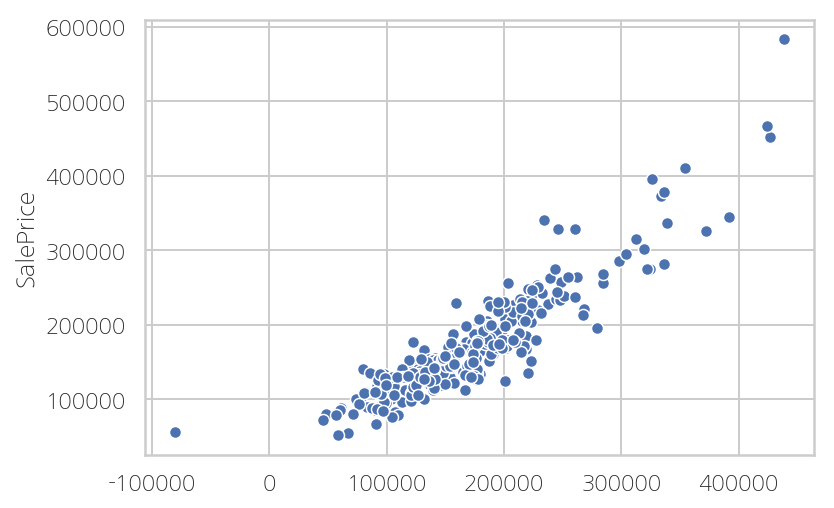

In [141]:
result_from = {'predicted' : yhat, 'SalePrice' : df_test_y}
ax = sns.scatterplot(x="predicted", y="SalePrice",data = result_from)

## Submit to kaggle

In [142]:
kaggle = result_norm.predict(df_test_kaggle)

In [146]:
kaggle_csv = pd.read_csv('sample_submission.csv')
kaggle_csv['SalePrice'] = kaggle

In [147]:
kaggle_csv.to_csv('submission_trial.csv', index=False)

In [148]:
kaggle.isnull().values.any()

False

![imgimg](3749.png)